<a href="https://colab.research.google.com/github/Lursios/projects/blob/main/Data_Related_Projects/ML_Project/Rock_Paper_Scissor_Image_Classfication/ML-Project-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Alpha Roissul

In [ ]:
#Importing important Dependencies
!pip install split-folders
import tensorflow as tf
import numpy as np
import pathlib
import zipfile
import PIL
import os
import splitfolders # or import splitfolders for help to split the initial folder

#Importing model related dependencies
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
#Importing the file so we can access it
dataset_url = "https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip"
data_dir = tf.keras.utils.get_file(fname = "rockpaperscissors.zip", origin=dataset_url)
#Extracting the zip file
local_zip = pathlib.Path(data_dir)
path_dir = "/tmp"
with zipfile.ZipFile(local_zip, 'r') as zip:
    # printing all the contents of the zip file
    #zip.printdir()
    zip.extractall(path= path_dir)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
322887680/322873683 [==============================] - 6s 0us/step


In [ ]:
#Checking the extracted file
#print(os.listdir("/tmp"))
data_dir = pathlib.Path("/tmp/rockpaperscissors/rps-cv-images")
#print(os.listdir("/tmp/rockpaperscissors/rock"))
#Accessing file and doing some checking it turns out after running the above code the images are saved as a png file.
image_count = len(list(data_dir.glob('*/*.png')))
rocks = list(data_dir.glob('rock/*'))
papers = list(data_dir.glob('paper/*'))
scissors = list(data_dir.glob('scissors/*'))

print(f"the total image is {image_count} in which {len(rocks)} are rocks, {len(papers)} are papers, and {len(scissors)} are scissors")

the total image is 2188 in which 726 are rocks, 712 are papers, and 750 are scissors


In [ ]:
#The Next step is to make a validation set and training set
#Define some parameter so it'll be easier to edit
import shutil
batch_size = 3
img_height = 100
img_width = 150
input_folder = "/tmp/rockpaperscissors/rps-cv-images"
#shutil.rmtree("/tmp/split_dir", ignore_errors=True) #activate this after the first run
output = "/tmp/split_dir" #where you want the split datasets saved. one will be created if it does not exist or none is set
splitfolders.ratio(input_folder, output=output, seed=1234, ratio=(.60, .40)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 2188 files [00:00, 2690.54 files/s]


In [ ]:
#Checking If the Split went correctly or not
val1 = len(os.listdir("/tmp/split_dir/val/paper"))
val2 = len(os.listdir("/tmp/split_dir/val/rock"))
val3 = len(os.listdir("/tmp/split_dir/val/scissors"))
print(val1,val2,val3)
tr1 = len(os.listdir("/tmp/split_dir/train/paper"))
tr2 = len(os.listdir("/tmp/split_dir/train/rock"))
tr3 = len(os.listdir("/tmp/split_dir/train/scissors"))
print(tr1,tr2,tr3)

285 291 300
427 435 450


In [ ]:
#Image augemanting with image data generator
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

val_datagen = ImageDataGenerator(
                    rescale=1./255)

In [ ]:
#Making the generator from the train directory and validation directory that has been augemented
train_dir = "/tmp/split_dir/train"
validation_dir = "/tmp/split_dir/val"

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height,img_width),
        batch_size=batch_size,
        # Because this is more than two class then change binary to categorical
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


In [ ]:
#Creating The Sequentiel Model based on TF documentation
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height,img_width, batch_size)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid')
])


In [ ]:
#Compiling the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 98, 148, 32)       896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 49, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 47, 72, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 23, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 21, 34, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 10, 17, 128)     

In [ ]:
accuracy_threshold = 98e-2
class my_callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if logs.get('accuracy') >= accuracy_threshold:
            print('\nFor Epoch', epoch, '\nAccuracy has reach = %2.2f%%' %(logs['accuracy']*100), 'training has been stopped.')
            self.model.stop_training = True
            epochs = epoch

In [ ]:
#Training The Model
epochs= 10
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=epochs,
  callbacks = [my_callbacks()]
)

Epoch 1/10
438/438 [==============================] - 173s 311ms/step - loss: 0.7376 - accuracy: 0.6601 - val_loss: 0.5633 - val_accuracy: 0.7112
Epoch 2/10
438/438 [==============================] - 135s 308ms/step - loss: 0.2761 - accuracy: 0.9123 - val_loss: 0.1231 - val_accuracy: 0.9658
Epoch 3/10
438/438 [==============================] - 119s 271ms/step - loss: 0.1915 - accuracy: 0.9329 - val_loss: 0.1492 - val_accuracy: 0.9452
Epoch 4/10
438/438 [==============================] - 123s 281ms/step - loss: 0.1592 - accuracy: 0.9482 - val_loss: 0.1609 - val_accuracy: 0.9429
Epoch 5/10
438/438 [==============================] - 121s 277ms/step - loss: 0.1322 - accuracy: 0.9604 - val_loss: 0.1030 - val_accuracy: 0.9749
Epoch 6/10
438/438 [==============================] - 117s 268ms/step - loss: 0.1389 - accuracy: 0.9573 - val_loss: 0.1426 - val_accuracy: 0.9646
Epoch 7/10
438/438 [==============================] - 116s 265ms/step - loss: 0.1015 - accuracy: 0.9703 - val_loss: 0.0819 -

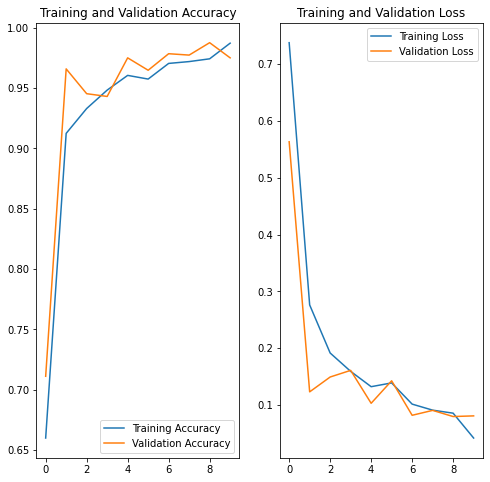

In [ ]:
#Visualizing The Training Result
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Saving IMG_20220901_230710.jpg to IMG_20220901_230710 (2).jpg
IMG_20220901_230710.jpg
0
rock


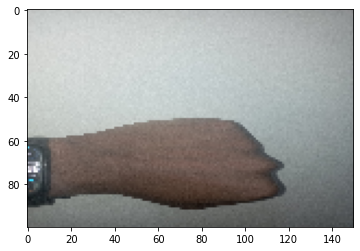

In [ ]:
#Testing the model !!
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=(100,150))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = np.argmax(model.predict(images, batch_size=10))

  print(fn)
  print(classes)
  if classes == 0:
    print('rock')
  elif classes == 1:
    print('paper')
  else:
    print('scissors')